values
METFORMIN_C
1    373
0    122
Name: count, dtype: int64
Epoch [50/200], Loss: 0.0005, DCor: 0.0133
Epoch [100/200], Loss: 0.0300, DCor: 0.0040
Epoch [150/200], Loss: 0.0000, DCor: 0.0022
Epoch [200/200], Loss: 0.0020, DCor: 0.0018


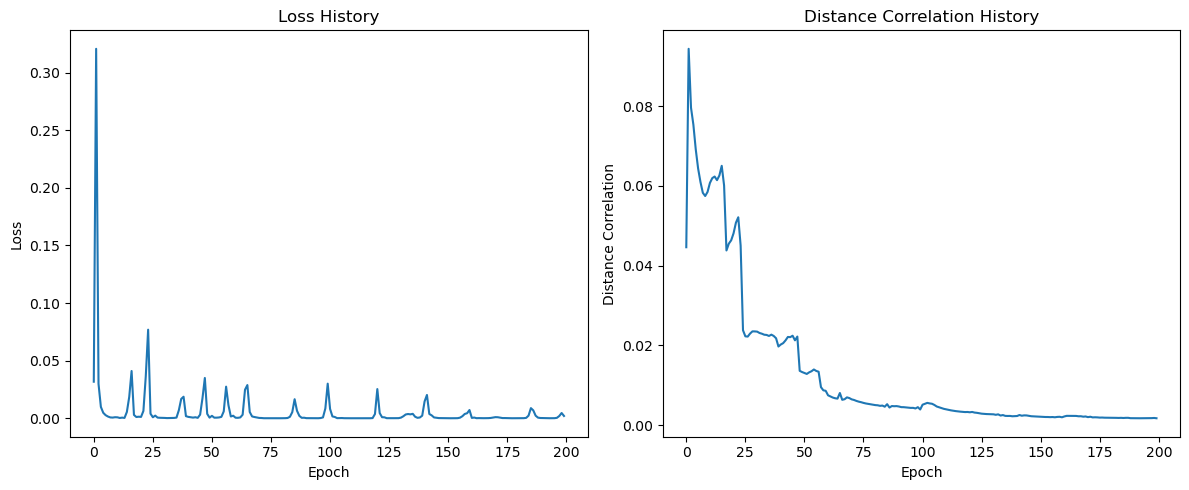

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def generate_synthetic_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    filtered_metadata = metadata[metadata['PATGROUPFINAL_C'] == 1]
    merged_data = pd.merge(filtered_metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['METFORMIN_C'].value_counts())

    metadata_columns = filtered_metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, criterion, optimizer, data_loader, num_epochs, criterion_classifier, optimizer_classifier):
    loss_history = []
    dcor_history = []
    model = model.to(device)
    criterion = criterion.to(device)
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        hidden_activations_list = []
        targets_list = []
        
        # Create an iterator from the data_loader
        data_iter = iter(data_loader)
        while True:
            try:
                # Get the next batch
                x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                # ----------------------------
                # Train drug classification (r_loss)
                # ----------------------------
                for param in model.encoder.parameters():
                    param.requires_grad = False

                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                r_loss = criterion_classifier(predicted_drug, y_batch)
                
                # Backward pass and optimization
                optimizer_classifier.zero_grad()
                r_loss.backward()
                optimizer_classifier.step()
                    
                for param in model.encoder.parameters():
                    param.requires_grad = True
                # ----------------------------
                # Train distiller (g_loss)
                # ----------------------------
                # Freeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = False
                
                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                loss = criterion(predicted_drug, y_batch)
                
                # Collect hidden activations and targets
                hidden_activations_list.append(encoded_features.detach().cpu())
                targets_list.append(y_batch.detach().cpu())
        
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
                epoch_loss += loss.item()
                for param in model.classifier.parameters():
                    param.requires_grad = True
            except StopIteration:
                # When the iterator is exhausted, break the loop
                break
        avg_loss = epoch_loss / len(data_loader)
        loss_history.append(avg_loss)
        
        # After epoch, concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)
        
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, DCor: {dcor_value:.4f}')
    
    return loss_history, dcor_history

# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 32
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 200
    batch_size = 64

    # Generate synthetic data with 654 features and imbalanced labels
    x_train, y_train = generate_synthetic_data()

    # Create stratified DataLoader
    data_loader = create_stratified_dataloader(x_train, y_train, batch_size)

    # Define model, loss, and optimizer
    model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
    criterion = PearsonCorrelationLoss().to(device)  # Use correlation loss
    optimizer = optim.Adam(model.encoder.parameters(), lr=learning_rate)
    criterion_classifier = nn.BCELoss().to(device)  # Use binary cross-entropy loss for classification
    optimizer_classifier = optim.Adam(model.classifier.parameters(), lr=learning_rate)

    # Move model and criteria to device
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)

    # Train the model
    loss_history, dcor_history = train_model(
        model, criterion, optimizer, data_loader, num_epochs, criterion_classifier, optimizer_classifier
    )

    # Plot the loss history and distance correlation history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title("Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(dcor_history)
    plt.title("Distance Correlation History")
    plt.xlabel("Epoch")
    plt.ylabel("Distance Correlation")

    plt.tight_layout()
    plt.show()


values
METFORMIN_C
1    373
0    122
Name: count, dtype: int64
values
PATGROUPFINAL_C
1    495
0    176
Name: count, dtype: int64
Epoch [50/200], Loss: 0.0012, DCor: 0.0075
Epoch [100/200], Loss: 0.0006, DCor: 0.0035
Epoch [150/200], Loss: 0.0001, DCor: 0.0019
Epoch [200/200], Loss: 0.0001, DCor: 0.0013


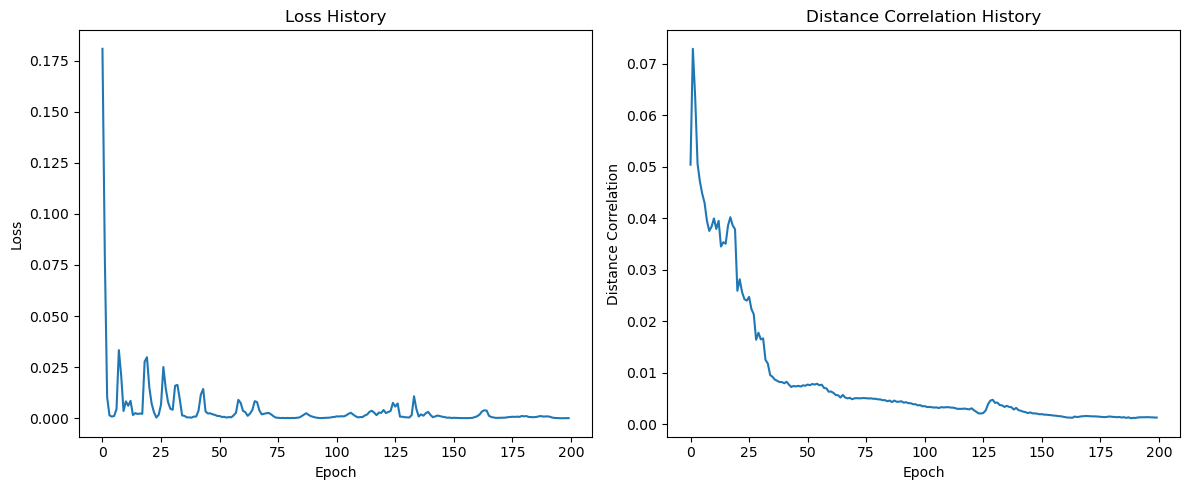

In [1]:
### data_all_loader has been added but not used yet
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def generate_synthetic_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    filtered_metadata = metadata[metadata['PATGROUPFINAL_C'] == 1]
    merged_data = pd.merge(filtered_metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['METFORMIN_C'].value_counts())

    metadata_columns = filtered_metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

def generate_all_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['PATGROUPFINAL_C'].value_counts())

    metadata_columns = metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, criterion, optimizer, data_loader, data_all_loader, num_epochs, criterion_classifier, optimizer_classifier):
    loss_history = []
    dcor_history = []
    model = model.to(device)
    criterion = criterion.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        hidden_activations_list = []
        targets_list = []
        
        # Create iterators from both data_loaders
        data_iter = iter(data_loader)
        data_all_iter = iter(data_all_loader)
        
        while True:
            try:
                # Get the next batch from data_all_loader
                x_all_batch, y_all_batch = next(data_all_iter)
                x_all_batch, y_all_batch = x_all_batch.to(device), y_all_batch.to(device)
                
                # Try to get the next batch from data_loader
                try:
                    x_batch, y_batch = next(data_iter)
                except StopIteration:
                    # If data_loader is exhausted, re-initialize it
                    data_iter = iter(data_loader)
                    x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # ----------------------------
                # Train drug classification (r_loss) using x_batch, y_batch
                # ----------------------------
                # Freeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = False

                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                r_loss = criterion_classifier(predicted_drug, y_batch)
                
                # Backward pass and optimization
                optimizer_classifier.zero_grad()
                r_loss.backward()
                optimizer_classifier.step()
                    
                # Unfreeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train distiller (g_loss) using x_batch, y_all_batch
                # ----------------------------
                # Freeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = False
                
                encoded_features_all = model.encoder(x_batch)
                predicted_drug_all = model.classifier(encoded_features_all)
                loss = criterion(predicted_drug_all, y_batch)
                
                # Collect hidden activations and targets
                hidden_activations_list.append(encoded_features_all.detach().cpu())
                targets_list.append(y_batch.detach().cpu())
        
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
                epoch_loss += loss.item()
                
                # Unfreeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = True

            except StopIteration:
                # When the data_all_loader iterator is exhausted, break the loop
                break

        # After the epoch, compute metrics or perform validation as needed
        avg_loss = epoch_loss / len(data_all_loader)
        loss_history.append(avg_loss)
        
        # Concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)
        
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, DCor: {dcor_value:.4f}')
    
    return loss_history, dcor_history


# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 32
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 200
    batch_size = 64

    # Generate synthetic data with 654 features and imbalanced labels
    x_train, y_train = generate_synthetic_data()
    x_all_train, y_all_train = generate_all_data()

    # Create stratified DataLoader
    data_loader = create_stratified_dataloader(x_train, y_train, batch_size)
    data_all_loader = create_stratified_dataloader(x_all_train, y_all_train, batch_size)

    # Define model, loss, and optimizer
    model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
    criterion = PearsonCorrelationLoss().to(device)  # Use correlation loss
    optimizer = optim.Adam(model.encoder.parameters(), lr=learning_rate)
    criterion_classifier = nn.BCELoss().to(device)  # Use binary cross-entropy loss for classification
    optimizer_classifier = optim.Adam(model.classifier.parameters(), lr=learning_rate)

    # Move model and criteria to device
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)

    # Train the model
    loss_history, dcor_history = train_model(
        model, criterion, optimizer, data_loader, data_all_loader, num_epochs, criterion_classifier, optimizer_classifier
    )

    # Plot the loss history and distance correlation history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title("Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(dcor_history)
    plt.title("Distance Correlation History")
    plt.xlabel("Epoch")
    plt.ylabel("Distance Correlation")

    plt.tight_layout()
    plt.show()
